# 1er Parcial procesamiento digital de imagenes.

## Descripción.
Se desea crear una solución infromatica que dada una imagen de examen (con el mecanismo de selección de una respuesta rellenando un circulo bajo una opción y número de pregunta) como la que se muestra debajo, sea posible de identificar las respuestas seleccionadas y sí estas son o no las correctas.

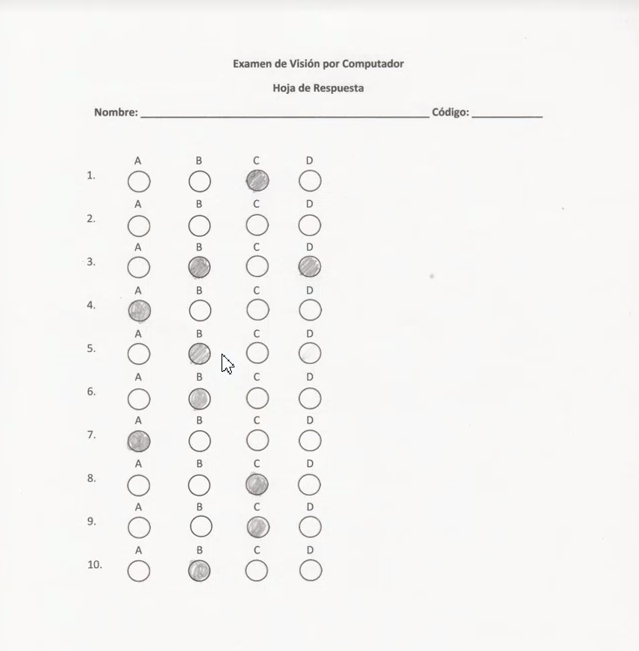

### Importación de librerías necesarias

In [119]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

### Definiendo metodos con responsabilidades específicas

In [120]:
def readImage(path, colors=1):
  return cv.imread(path, colors)

In [121]:
def showImage(image, cmap=None):
  plt.imshow(image, cmap=cmap)

### Importando y describiendo imagen

In [122]:
exam = readImage("example-exam.jpeg", 0)

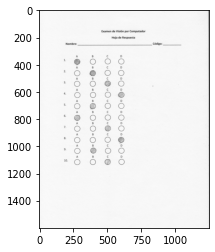

In [123]:
showImage(exam, cmap="gray")

In [124]:
exam.shape

(1600, 1246)

## Tratameinto de la Imagen

### Recorte de area de interés o area objetivo

In [125]:
init_x = 150
init_y = 300
width  = init_x + 500
height = init_y + 900

cropped_image = exam[init_y:height, init_x:width]

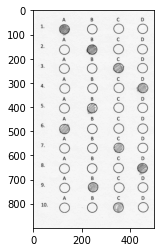

In [126]:
showImage(cropped_image, cmap="gray")

### Filtrado de ruido o sombras

In [127]:
kernel_size = 5
gaussiana = cv.GaussianBlur(cropped_image, (kernel_size, kernel_size), 0)

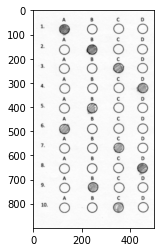

In [128]:
showImage(gaussiana, cmap="gray")

### Binarizando imagen

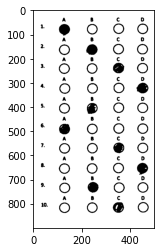

In [129]:
threshold, binary_image = cv.threshold(gaussiana, 220, 255, cv.THRESH_BINARY)
showImage(binary_image, cmap="gray")

### Resalte de las opciones rellenadas

In [130]:
structure_size = 4
structure = np.ones((structure_size,structure_size),dtype=np.uint8)

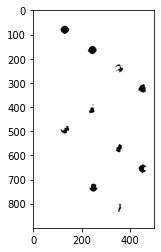

In [131]:
dilated_image = cv.dilate(binary_image, structure, iterations=3)
showImage(dilated_image, cmap="gray")

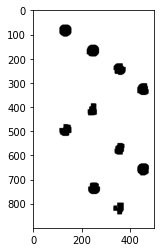

In [132]:
eroded_image = cv.erode(dilated_image, structure, iterations=5)
showImage(eroded_image, cmap="gray")

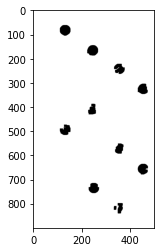

In [133]:
closing_image = cv.morphologyEx(binary_image, cv.MORPH_CLOSE, structure, iterations = 3)
showImage(closing_image, cmap="gray")

Se observa mejor resultado realizando las operaciones de manera individual he iterada que por ejemplo utilizando la morfología close.

### Detectando y ubicando los elementos

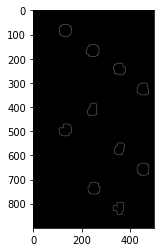

In [134]:
edges = cv.Canny(eroded_image,50,150)
showImage(edges, "gray")

In [135]:
countours, hierarchy = cv.findContours(edges.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
print("Contornos encontrados: {}".format(len(countours)))

Contornos encontrados: 10


In [136]:
hierarchy

array([[[ 1, -1, -1, -1],
        [ 2,  0, -1, -1],
        [ 3,  1, -1, -1],
        [ 4,  2, -1, -1],
        [ 5,  3, -1, -1],
        [ 6,  4, -1, -1],
        [ 7,  5, -1, -1],
        [ 8,  6, -1, -1],
        [ 9,  7, -1, -1],
        [-1,  8, -1, -1]]], dtype=int32)

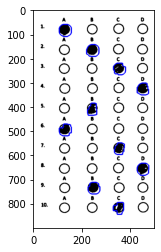

In [137]:
image_three_channel = cv.cvtColor(binary_image,cv.COLOR_GRAY2RGB)

contours_to_draw = -1
blue = (0,0,255)
thickness = 3

result = cv.drawContours(image_three_channel,countours,contours_to_draw, blue, thickness)
showImage(result)

### Calculo de centroídes
Dado que ya tenemos el contorno de las opciones seleccionadas, procedemos a ubicar los centroídes de cada una para indicar la respuesta seleccionada en cada pregunta.

In [138]:
def calculateCentroid(countour):
#  print(countour)
  moment = cv.moments(countour)
#  print(moment)
  x = int(moment["m10"]/moment["m00"])
  y = int(moment["m01"]/moment["m00"])
 # print("x, y: {}, {}".format(x,y))
  return x,y

In [139]:
possible_answers = ["A", "B", "C", "D"]
number_questions = list(range(1,11))

distance_answers   = 120
distance_questions = 80

answers_student = []

for countour in countours:
  x, y = calculateCentroid(countour)

  question_pos = round(float(y/distance_questions))
  answer_pos   = round(float(x/distance_answers))

  answers_student.append((1 if question_pos == 0 else number_questions[question_pos-1],
                          1 if answer_pos == 0 else possible_answers[answer_pos-1]))
  

In [140]:
def printAnswerPerQuestion(answer, question):
  print("{}.        {}".format(question, answer))

In [141]:
# Imprimiendo respuestas estudiante

print("Pregunta - Respuesta")

for answer in answers_student:
  printAnswerPerQuestion(answer[1], answer[0])

Pregunta - Respuesta
10.        C
9.        B
8.        D
7.        C
6.        A
5.        B
4.        D
3.        C
2.        B
1.        A


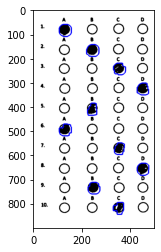

In [142]:
showImage(result)

### Validando Respuestas correctas
Supongamos que tenemos una estructura que tiene las respuestas correctas, entonces prodemos validadar cuanto ha sacado el estudiante

In [147]:
correct_answers = [(1, "A"), (2, "C"), (3, "C"), (4, "B"), (5, "D"), (6, "D"), (7, "B"), (8, "D"), (9, "B"), (10, "C")]

In [149]:
def findQuestion(number_question, question_answers):
  for question_answer in question_answers:
    if number_question == question_answer[0]:
      return question_answer

In [154]:

def rateAnswers(correct_answers, student_answers):

  right = 0
  wrong = 0

  for answer in correct_answers:
    student_answer = findQuestion(answer[0], answers_student)
    if answer[1] == student_answer[1]:
      print("Pregunta {}. con respuesta {} Correcta".format(student_answer[0], student_answer[1]))
      right = right + 1
    else:
      print("Pregunta {}. con respuesta {} Incorrecta".format(student_answer[0], student_answer[1]))
      wrong = wrong + 1
  
  print("Total correctas:    {}".format(right))
  print("Total incorrectas:  {}".format(wrong))
  print("Nota final: {}".format(right))

In [155]:
# Calificando

rateAnswers(correct_answers, answers_student)

Pregunta 1. con respuesta A Correcta
Pregunta 2. con respuesta B Incorrecta
Pregunta 3. con respuesta C Correcta
Pregunta 4. con respuesta D Incorrecta
Pregunta 5. con respuesta B Incorrecta
Pregunta 6. con respuesta A Incorrecta
Pregunta 7. con respuesta C Incorrecta
Pregunta 8. con respuesta D Correcta
Pregunta 9. con respuesta B Correcta
Pregunta 10. con respuesta C Correcta
Total correctas:    5
Total incorrectas:  5
Nota final: 5
